In [89]:
import pandas as pd
import numpy as np
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subset_data = data.sample(n=4000, random_state=42)  # Use a specific random_state for reproducibility

# Display information about the subset



In [90]:
print(subset_data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2644 to 1469
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4000 non-null   int64 
 1   keyword   3971 non-null   object
 2   location  2648 non-null   object
 3   text      4000 non-null   object
 4   target    4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB
None


In [91]:
subset_data[data.keyword.notna()].head()


<ipython-input-91-05e4f2e60b9f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_data[data.keyword.notna()].head()


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


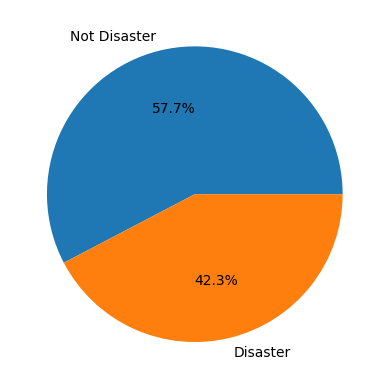

In [92]:
import matplotlib.pyplot as plt
plt.pie(subset_data.target.value_counts(),
        labels=['Not Disaster','Disaster'],
        autopct='%1.1f%%')
plt.show()

In [98]:
import re

def clean_text_data(df):
    # Make text lowercase
    df['text'] = df['text'].str.lower()

    # Remove links (URLs)
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

    # Remove emojis (Unicode characters)
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    return df

In [99]:
data = clean_text_data(subset_data)
test = clean_text_data(test)

In [100]:
import tensorflow as tf

VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(subset_data.text.to_list())

vectorized_text = encoder(subset_data.text).numpy()

vectorized_text[:5]

array([[  27,   12,   24,    3,   47,  266,   16,   72,  277,    1,  441,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    1,  575,    8,   62,   10,    1,   30,   96,    1,    4,
           3,  350,  105,   10,    1,    7,    1, 1805,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    1,   94,    1,    2,    1,   65,   72,    1,    3,    1,
           4,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 812,   83,    5,  160, 1637,  110,   23,  226,    8,  144,    5,
         455,  229,   10,  554,   14,  426,   64,    3,  226,  308,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   4, 1357,    5,  298,  797,    6,    1,    1,    3,    1,  759,
          58,   16,    1,    1,  126,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import f1_score

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          128000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1024)              263168    
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 589825 (2.25 MB)
Trainable params: 58982

In [103]:
def custom_learning_rate(epoch):
    initial_lr = 0.00006
    drop = 0.95
    epochs_drop = 3

    lr = initial_lr * (drop ** (epoch // epochs_drop))

    return lr
lr_scheduler = LearningRateScheduler(custom_learning_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [104]:
history = model.fit(np.array(data.text),
                    data.target,
                    epochs=25,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/25
100/100 [==============================] - 25s 144ms/step - loss: 0.6870 - accuracy: 0.5697 - val_loss: 0.6734 - val_accuracy: 0.5913 - lr: 6.0000e-05
Epoch 2/25
100/100 [==============================] - 11s 109ms/step - loss: 0.6665 - accuracy: 0.5878 - val_loss: 0.6286 - val_accuracy: 0.6850 - lr: 6.0000e-05
Epoch 3/25
100/100 [==============================] - 9s 89ms/step - loss: 0.5825 - accuracy: 0.7337 - val_loss: 0.5054 - val_accuracy: 0.7837 - lr: 6.0000e-05
Epoch 4/25
100/100 [==============================] - 11s 110ms/step - loss: 0.4712 - accuracy: 0.8009 - val_loss: 0.4623 - val_accuracy: 0.8000 - lr: 5.7000e-05
Epoch 5/25
100/100 [==============================] - 11s 110ms/step - loss: 0.4152 - accuracy: 0.8278 - val_loss: 0.4604 - val_accuracy: 0.7887 - lr: 5.7000e-05
Epoch 6/25
100/100 [==============================] - 9s 95ms/step - loss: 0.3792 - accuracy: 0.8469 - val_loss: 0.4651 - val_accuracy: 0.7950 - lr: 5.7000e-05
Epoch 7/25
100/100 [============

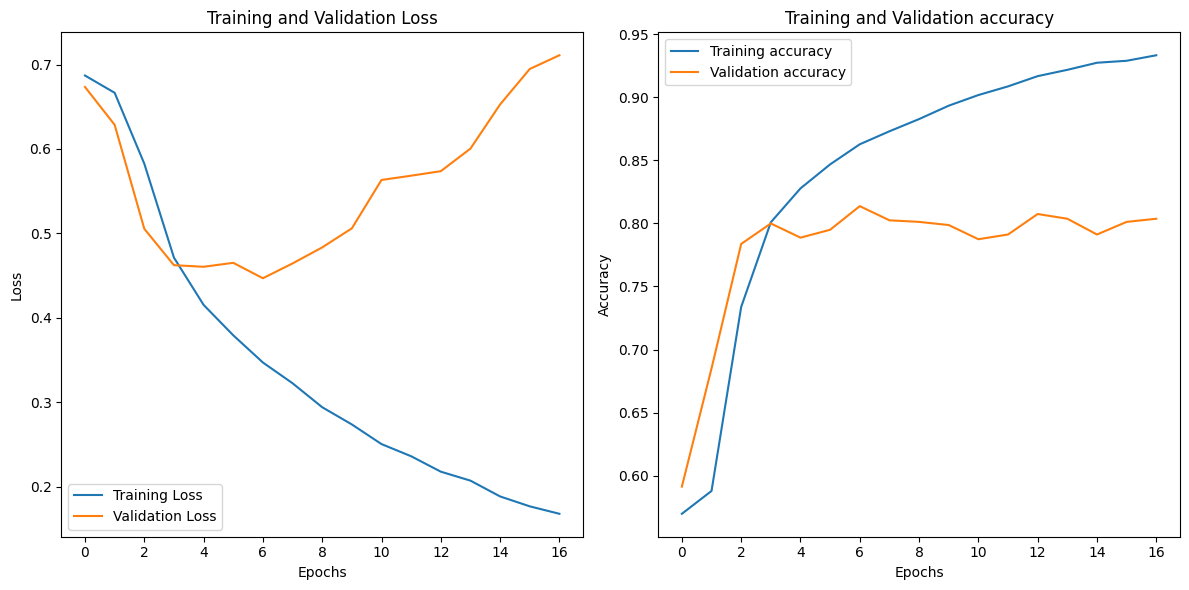

In [105]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

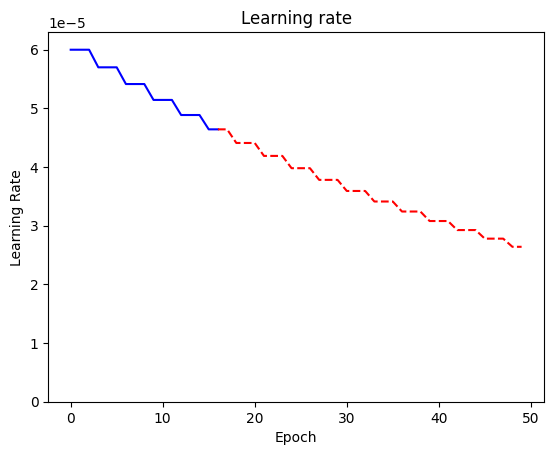

In [106]:
x = range(50)
n = len(history.history['lr'])
lrs_0 = [custom_learning_rate(i) for i in x[:n]]
lrs_1 = [custom_learning_rate(i) for i in x[n-1:]]
plt.plot(x[:n], lrs_0, color='blue')
plt.plot(x[n-1:], lrs_1, 'r--')
plt.ylim(0, max(history.history['lr'])*1.05)
plt.title('Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [107]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.5).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 5s 24ms/step
